# Titanic

This notebook is to explore the titanic dataset and produce a machine learning model that can predict which passengers survived or not depending on various features.

# Data preparation

**Option 1:**

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import seaborn as sn
import sqlalchemy
import seaborn as sns
%matplotlib inline

# Kaggle submission tools
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# set chart style
plt.style.use('ggplot')

# create database engine
engine = sqlalchemy.create_engine(
    url = 'postgresql://danielsuarez-mash@localhost/titanic_project?'
)

train = pd.read_sql('SELECT * FROM train', engine)
test = pd.read_sql('SELECT * FROM test', engine)
eg_submission = pd.read_sql('SELECT * FROM gender_submission', engine)

**Option 2:**

In [2]:
# # download competition data
# api.competition_download_files('titanic')

# # get datasets
# with zipfile.ZipFile(file = 'titanic.zip') as my_zip:
#     with my_zip.open(name = 'train.csv') as train_file:
#         train = pd.read_csv(train_file)
#     with my_zip.open(name = 'test.csv') as test_file:
#         test = pd.read_csv(test_file)
#     with my_zip.open(name = 'gender_submission.csv') as gender_sub:
#         eg_submission = pd.read_csv(gender_sub)

# Exploratory Data Analysis

In [3]:
train_copy = train.copy()
train_copy.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,None,S


In [4]:
print(train_copy.info())
print('*'*100)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    float64
 7   parch        891 non-null    float64
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 83.7+ KB
None
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count 

In [5]:
train_copy.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## EDA Objectives

1. What features are useful for helping to predict survival?
2. Are there any data quality issues?
3. Are there any opportunities to engineer new features?

Text(0.5, 0, 'Survived (0 false, 1 true)')

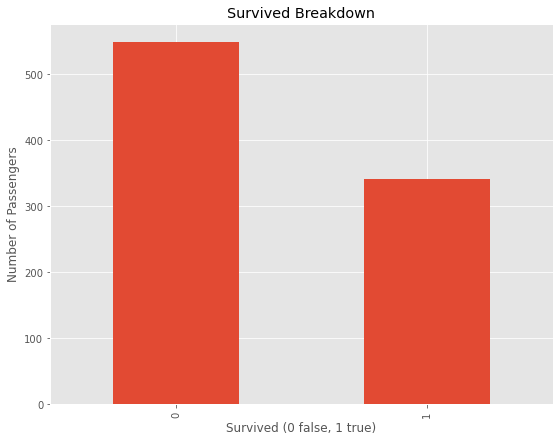

In [6]:
train_copy['survived'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.title('Survived Breakdown')
plt.ylabel('Number of Passengers')
plt.xlabel('Survived (0 false, 1 true)')

## Part 1: What columns are useful for helping to predict survival?

### Pclass (Passenger Class)


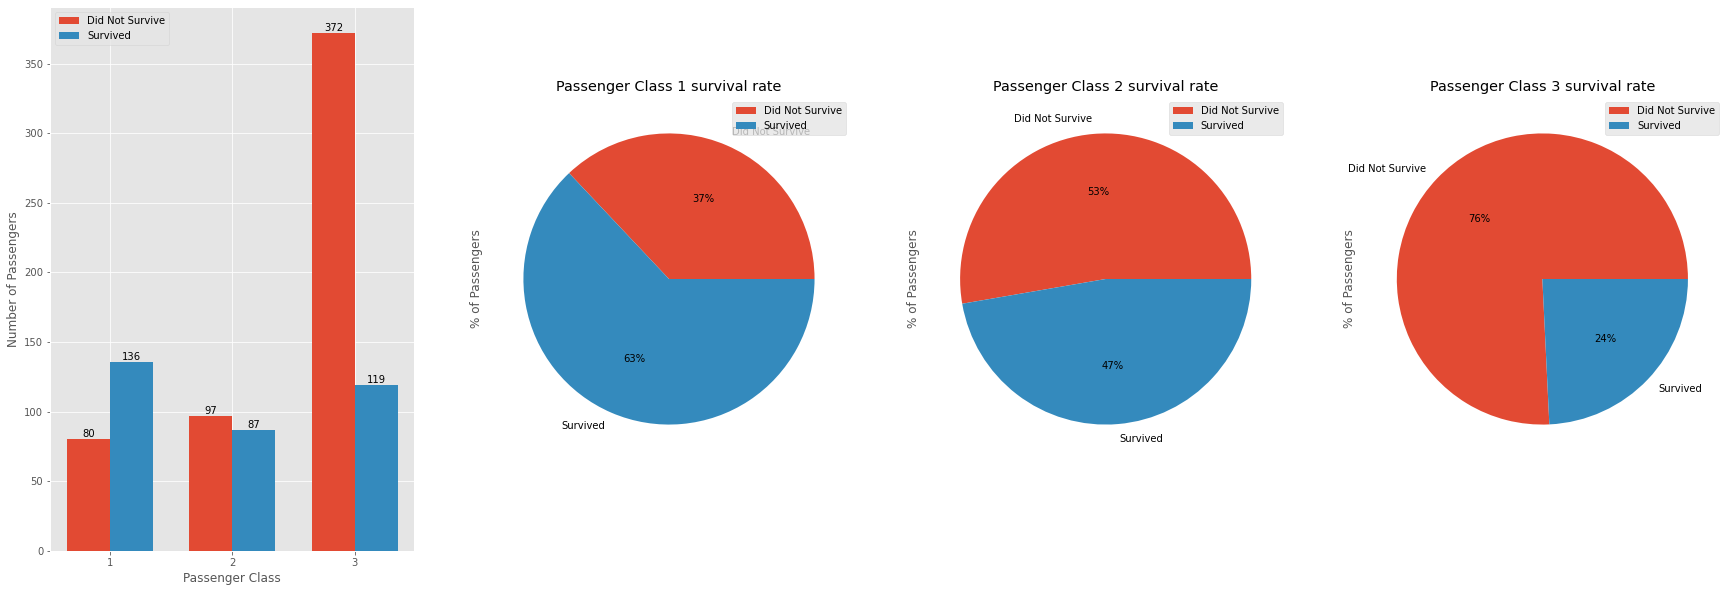

In [7]:
# group by
data = train_copy.groupby(['pclass', 'survived']).passengerid.count().unstack()

# set up figure and axes
figure, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize = (30,10))

####### BAR CHART #######

x = np.array([1, 2, 3]) # set passenger classes as x-axis
width = 0.35 # width of bars

bars_1 = ax.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive') # first set of bars
bars_2 = ax.bar(x = x+width/2, height = data[1], width = width, label = 'Survived') # second set of bars

ax.set_xticks(ticks = x) # make sure only pclasses are shown on x-axes
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Number of Passengers')
ax.bar_label(container=bars_1, labels = data[0]) # label 1st set of bars
ax.bar_label(container=bars_2, labels = data[1]) # label 2nd set of bars
ax.legend()

####### PIE CHARTS ########

# survival rate for pclass 1
pclass1 = train_copy[train_copy['pclass'] == 1].groupby('survived').passengerid.count()
pclass1.plot.pie(ax = ax1, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax1.set_title('Passenger Class 1 survival rate')
ax1.set_ylabel('% of Passengers')
ax1.legend()

# survival rate for pclass 2
pclass2 = train_copy[train_copy['pclass'] == 2].groupby('survived').passengerid.count()
pclass2.plot.pie(ax = ax2, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax2.set_title('Passenger Class 2 survival rate')
ax2.set_ylabel('% of Passengers')
ax2.legend()

# survival rate for pclass 3
pclass3 = train_copy[train_copy['pclass'] == 3].groupby('survived').passengerid.count()
pclass3.plot.pie(ax = ax3, radius=1, autopct='%.0f%%', labels = ['Did Not Survive', 'Survived'])
ax3.set_title('Passenger Class 3 survival rate')
ax3.set_ylabel('% of Passengers')
ax3.legend()

1. Is Pclass a good feature we can use to predict survival?

From the charts above, we can see **a large number of passengers in class 3 did not survive**. In fact, the proportion of passengers which survived rises with the class they were in. One assumption we could make then is that wealthier passengers with a 1st class ticket were prioritised in some way during the evacuation. But we should investigate this.

- **Investigate whether there really is an association between passenger class and survival. Or is passenger class a proxy for another more influential factor. For example, were passengers in Pclass 1 higher up on the boat and/or closer to lifeboats?**
 
    
2. Are there any data quality issues with Pclass?

No missing values in both training or testing datasets. ***To interrogate the feature for any incorrect data, we could investigate the fare distribution for each Passenger Class.***

3. Are there any opportunities to data engineer new features?

Passenger Class is a simple categorical feature which no other information which we can extract. However, it will be worth investigating any co-linearities (correlation) with other features. I'm going to suspect that this feature is associated with the fare feature. 

- **Investigate whether pclass is correlated with fare and if there are any opportunities to combine these features together.**

### Sex

Text(0, 0.5, '% of Passengers')

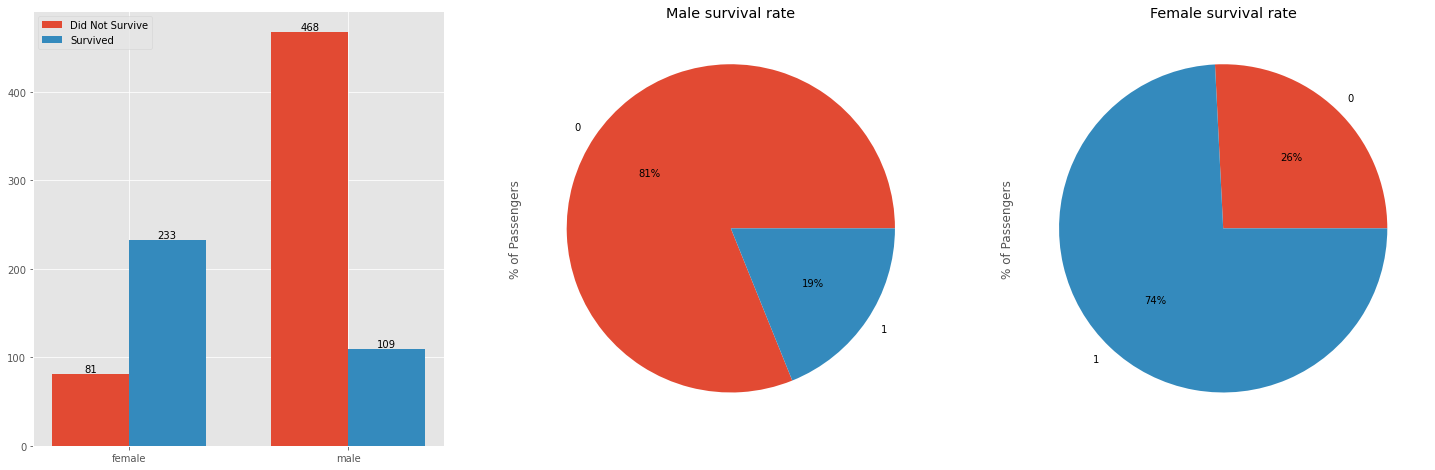

In [8]:
# group by
data = train_copy.groupby(['sex', 'survived']).passengerid.count().unstack()

# set up figure
figure, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (25,8))

####### BAR CHART #######

x = np.array([0, 1])
width = 0.35

bars_nsrv = ax.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive')
bars_srv = ax.bar(x = x+width/2, height = data[1], width = width, label = 'Survived')
ax.set_xticks(ticks = x, labels = ['female', 'male'])
ax.bar_label(container = bars_nsrv, labels = data[0])
ax.bar_label(container = bars_srv, labels = data[1])
ax.legend()

####### PIE CHARTS #######

# survival rate for pclass 1
male = train_copy[train_copy['sex'] == 'male'].groupby('survived').passengerid.count()
male.plot.pie(ax = ax1, radius=1, autopct='%.0f%%')
ax1.set_title('Male survival rate')
ax1.set_ylabel('% of Passengers')

# survival rate for pclass 2
female = train_copy[train_copy['sex'] == 'female'].groupby('survived').passengerid.count()
female.plot.pie(ax = ax2, radius=1, autopct='%.0f%%')
ax2.set_title('Female survival rate')
ax2.set_ylabel('% of Passengers')

1. Is this a useful feature for helping to predict survival?

Yes, I'm going to assume females were prioritised during the evacuation. However we should investigate this.

- ***We should investigate the female group to see how they make up other features. For example, do they all sit in one age group? Do they all belong to one Passenger Class? Did a lot of them have children?***

2. Are there any data quality issues?

No missing values in either dataset. However, there are less females than males but not by much. It's worth noting that ML models can't learn a pattern from few examples and so we need sufficient amounts of data to allow our ML model to learn. There are sufficient female data points here to not consider any resampling techniques.

3. Are there any opportunities to engineer new features?

Not really. Sex is, again, a simple categorical feature with no extra info we can extract.

### Age

Text(0.5, 0, 'Age Group')

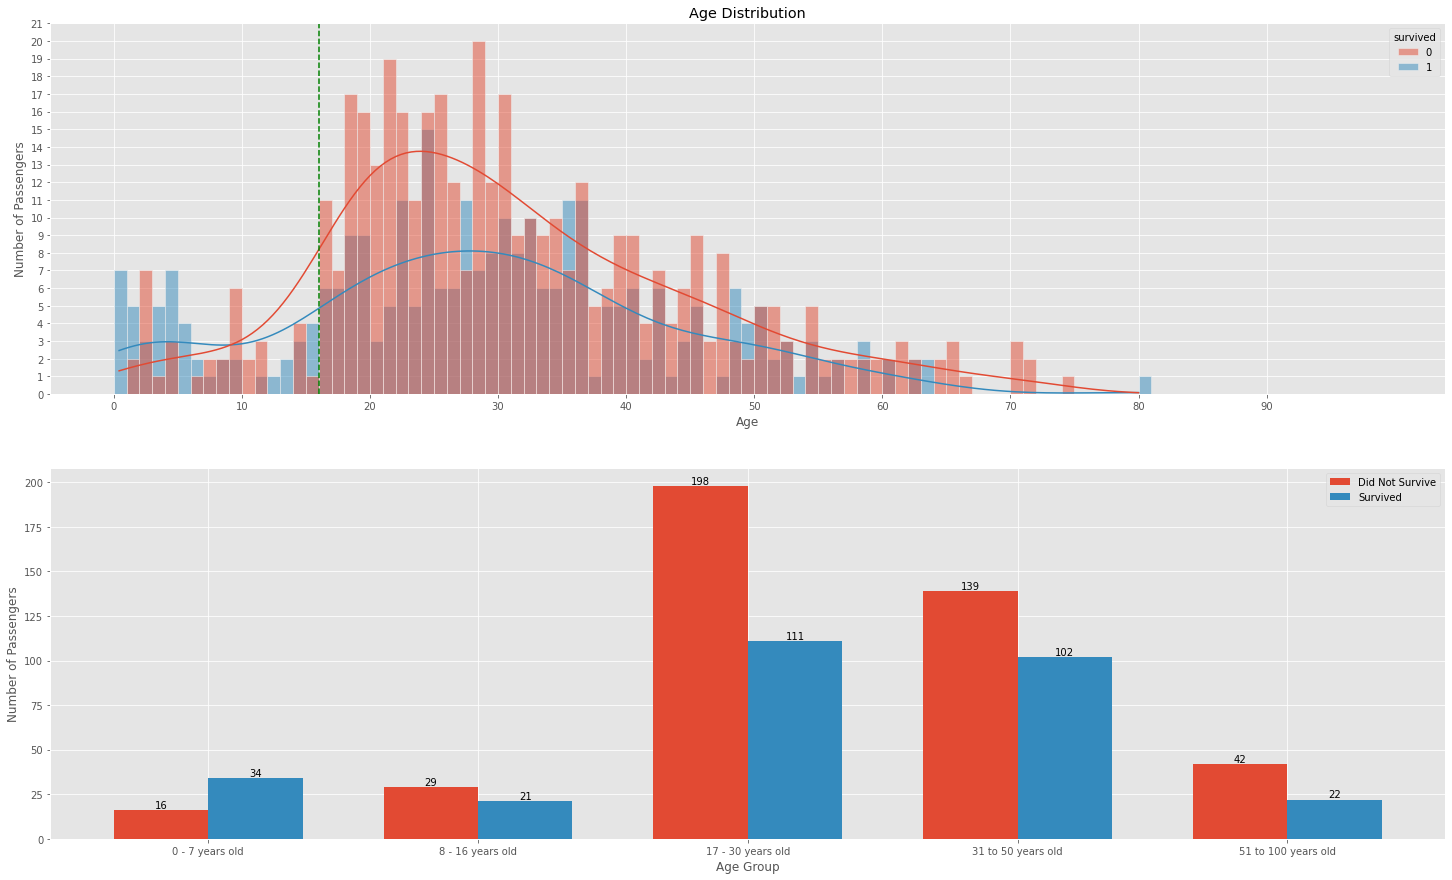

In [9]:
# set up figure
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (25, 15))

# set bins
age_bins = np.arange(start = 0, stop = 100, step = 1)
xticks = np.arange(start = 0, stop = 100, step = 10)
yticks = np.arange(start = 0, stop = 22, step = 1)

######## AGE DISTRIBUTION CHART #########
sns.histplot(data = train_copy, x = 'age', hue = 'survived', kde = True, bins = age_bins, ax = ax1)
ax1.axvline(x = 16, color = 'green', linestyle = '--')
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Passengers')
ax1.set_xticks(ticks = xticks)
ax1.set_yticks(ticks = yticks);

######## SURVIVAL RATE BY AGE GROUP BAR CHART #########
age_groups = pd.IntervalIndex.from_arrays(left = (0, 7, 16, 30, 50),
                                          right = (7, 16, 30, 50, 100))

x = np.arange(0, 5, 1)

train_copy['age_group'] = pd.cut(x = train_copy['age'], 
                            bins = age_groups, 
                            include_lowest = True)

data = train_copy.groupby(['age_group', 'survived']).passengerid.count().unstack()
not_surv_bar = ax2.bar(x = x-width/2, height = data[0], width = width, label = 'Did Not Survive')
surv_bar = ax2.bar(x = x+width/2, height = data[1], width = width, label = 'Survived')
ax2.legend()
ax2.set_xticks(ticks = [0, 1, 2, 3, 4], labels = ['0 - 7 years old', '8 - 16 years old', '17 - 30 years old', '31 to 50 years old', '51 to 100 years old'])
ax2.bar_label(container = not_surv_bar, labels = data[0])
ax2.bar_label(container = surv_bar, labels = data[1])
ax2.set_ylabel('Number of Passengers')
ax2.set_xlabel('Age Group')

1. Is this a useful feature for helping to predict survival?

Yes, as shown above, children and babies under roughly 16 years old were most likely prioritised and hence saw higher survival rates than any other age group. An even higher proportion of children under 7 years old survived. This is in line with what we would expect from human nature: prioritising the vulnerable and allowing the stronger to take on more risk.  

- ***We should investigate to see whether there are any other reasons for a low survival rate amongst the 17-30 age group other than the fact they are more likely to be 'strong and healthy'. Was this group majority male? Was this group majority in passenger class 3?

2. Are there any data quality issues?

Yes, we have missing values in both datasets but not a huge amount. 

- ***Given that clearly a useful feature for predicting survival, we need to make sure we deal with missing values in the best way possible. If we use the mean to impute missing values and if the mean is in the (15-65) age group then we will be increasing the chance of a 'did not survive' prediction. We should see if the other features can help us determine somebody's age.***

3. Are there any opportunities to engineer new features?

We have already binned passengers into age groups which should summarise survival rates amongst different ages clearly.

### SibSp - Number of siblings/spouses

Text(0.5, 1.0, 'Survived by Number of Siblings/Spouses')

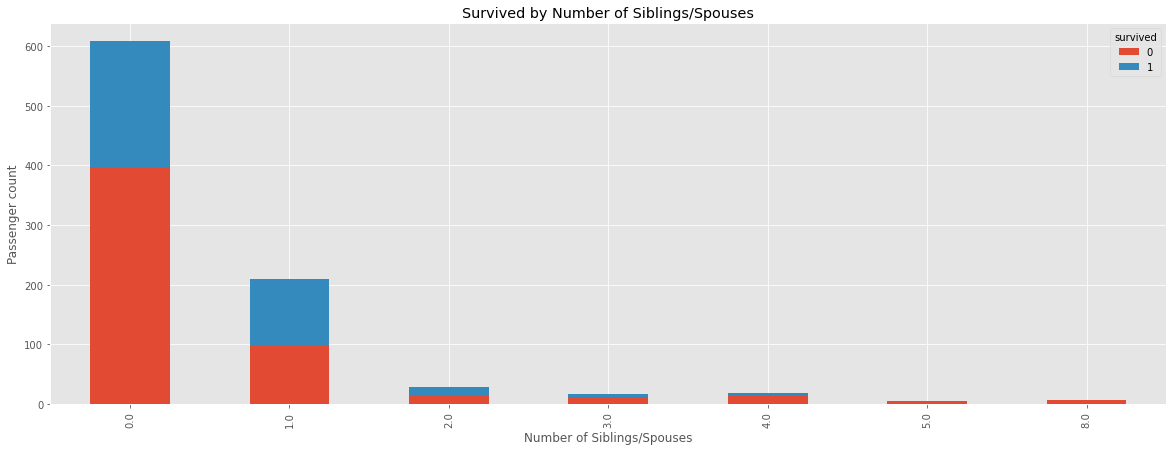

In [10]:
figure, ax1 = plt.subplots(1, figsize = (20, 7))

data = train_copy.groupby(['sibsp', 'survived']).passengerid.count().unstack().plot(kind = 'bar', ax = ax1, stacked = True)
ax1.set_ylabel('Passenger count')
ax1.set_xlabel('Number of Siblings/Spouses')
ax1.set_title('Survived by Number of Siblings/Spouses')

1. Is this a useful predictor for survival?

The majority of passengers did not have any siblings or spouses with them on the Titanic. The survival split in this group is equal to the overall survival split meaning that this group could be a representative sample of passengers onboard the Titanic. 

Just over 50% of those in group 1 survived. The survival rate in group 2 and beyond starts to fall. This pattern might be useful as a predictor for survival. So yes, this feature, with some feature engineering, could be a useful predictor. 

- ***Why does group 0 have a better survival rate than group 1? Were there more males in group 0? Did group 0 contain a more passengers between 15 and 65 years of age? Were there more passengers in Passenger Class 3 in group 0?***
- ***Why do we see such low survival rates among group 3 and beyond? What type of passengers do we see in these groups?***

2. Are there any data quality issues?

No missing data for either dataset. However, there are not many passengers with 3 or more siblings/spouses which might make it hard for an ML model to learn from.

3. Are there any opportunities for feature engineering?

Yes, it might be a good idea to reduce the number of categories in this feature. For example, instead of 8 groups we could have group 1 - (0 siblings/spouses), group 2 - (1 - 3 siblings/spouses) and then group 3 - (>3 siblings/spouses).

### Parch - number of parents/children

Text(0.5, 1.0, 'Survived by Number of Parents/Children')

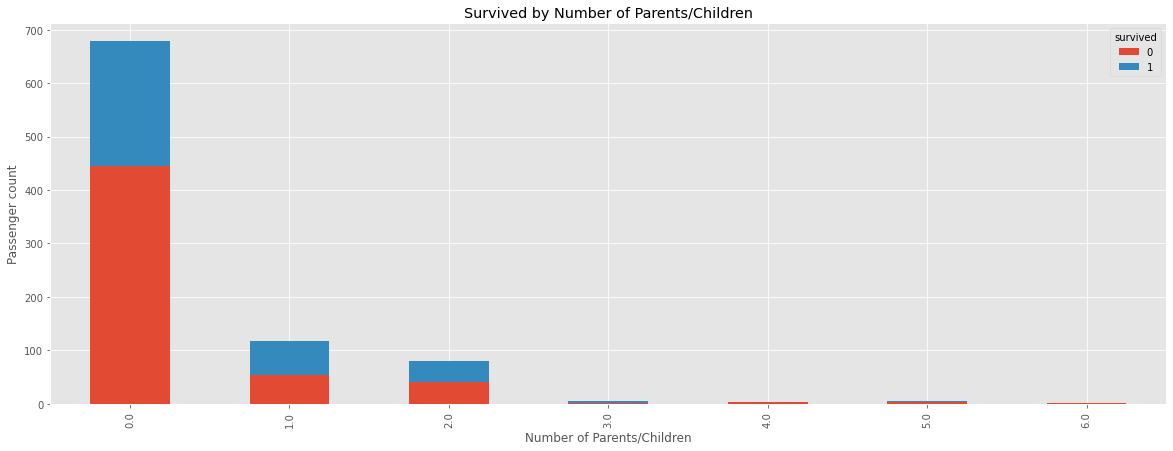

In [11]:
figure, ax1 = plt.subplots(1, figsize = (20, 7))

train_copy.groupby(['parch', 'survived']).passengerid.count().unstack().plot(kind = 'bar', ax = ax1, stacked = True)
ax1.set_ylabel('Passenger count')
ax1.set_xlabel('Number of Parents/Children')
ax1.set_title('Survived by Number of Parents/Children')

1. Is this a good feature to predict survival?

Similar to SibSp, the majority of passengers do not have any parents or children with them. The survival split in this group is also identical the overall titanic survival split meaning that this group could contain a representative sample of passengers onboard the titanic.

The rate of survival increases in group 1, which is also similar to the SibSp feature. An assumption could be that there are a relatively higher number of mothers and daughters in this category. This might explain why the survival rate decreases for group 2, as this group would contain more fathers. 

- ***Investigate the make up of group 0, 1 and 2. What is the reason behind their difference in survival rate? Did group 1 have a better survival rate because of a combination of gender make up and very young children?***

2. Are there any data quality issues?

No missing values. There is imbalance between groups but not enough to be a concern for machine learning. However, there is a very small amount of passengers with 3 or more parents/children. One would assume that these passengers are parents with 3 or more children, but this needs to be verified.

- ***Verify whether passengers in group 3 and above were all exclusively parents with 3 or more children.***

### Ticket

In [12]:
train_copy

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,None,S,"(16.0, 30.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,"(30.0, 50.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,None,S,"(16.0, 30.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,"(30.0, 50.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,None,S,"(30.0, 50.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,None,S,"(16.0, 30.0]"
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,"(16.0, 30.0]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,2.0,W./C. 6607,23.4500,None,S,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.0000,C148,C,"(16.0, 30.0]"


As shown above, this feature is a little more tricky than previous ones. From what we can see above, it appears as though ticket strings are made up of an initial code followed by a number. Some tickets have a code and some don't. ***Let's check how many parts make up a ticket string.***

In [13]:
# copy the dataset
train_copy = train_copy.copy()

# split the ticket into parts
train_copy['ticket_split'] = train_copy['ticket'].str.split(' ')

# how many parts do we get?
number_of_parts = [len(x) for x in train_copy['ticket_split']]
number_of_parts.sort(reverse = True)
print('Count of Number of Ticket Parts')
pd.Series(number_of_parts).value_counts()

Count of Number of Ticket Parts


1    665
2    213
3     13
dtype: int64

Most tickets contain just a number. ***So is there a factor which determines whether a ticket has a code as well? And why are there 13 tickets with 3 parts?***

In [14]:
# get list of ticket codes where possible.
train_copy['ticket_code'] = train_copy['ticket_split'].apply(lambda x: x[0] if len(x) == 2 else 'NA')
train_copy['ticket_number'] = train_copy['ticket_split'].apply(lambda x: x[2] if len(x) == 3 else (x[1] if len(x) == 2 else x[0]))

# seperate passengers based on whether they have a ticket code or not
train_copy['has_code'] = ~(train_copy['ticket_code'] == 'NA')

# get numerical columns
num_cols = [col for col in train_copy.columns if train_copy[col].dtype in (['int64', 'float64'])]
num_cols.remove('passengerid')

<AxesSubplot:xlabel='has_code'>

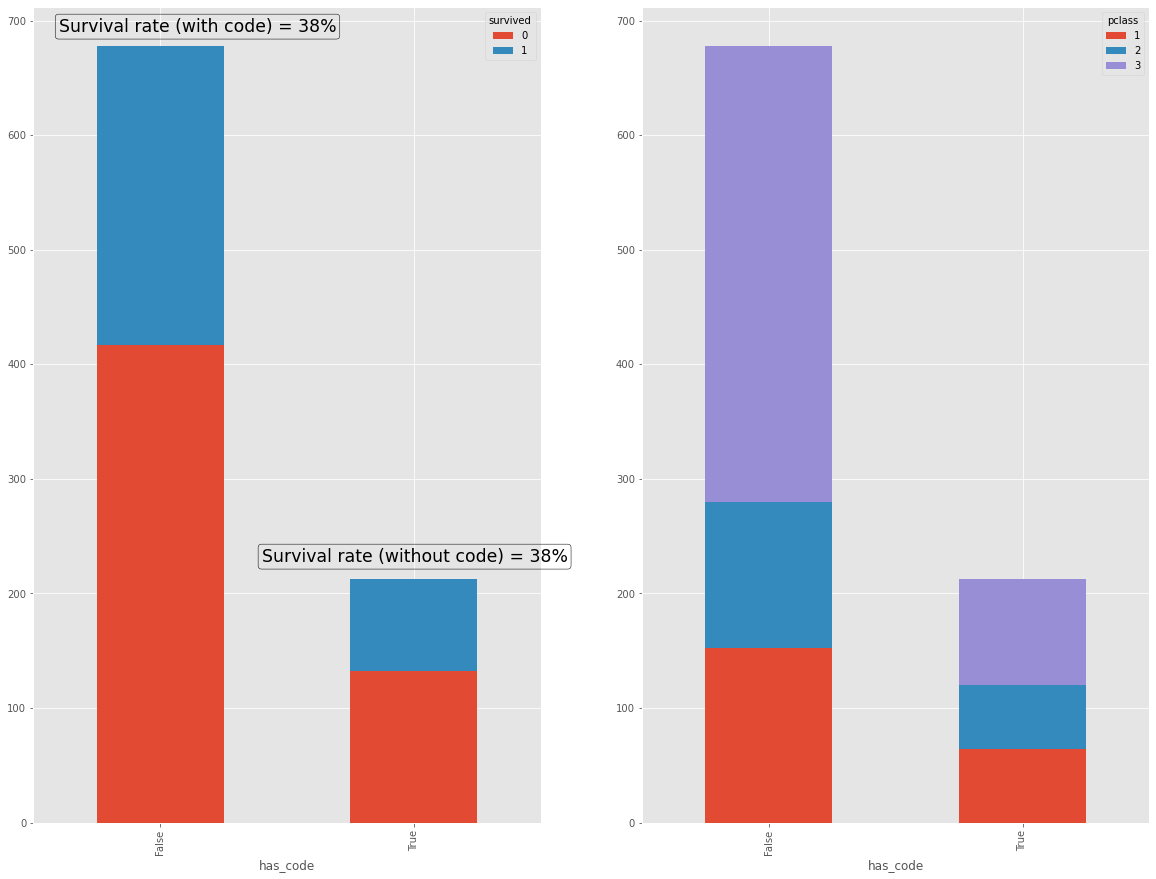

In [15]:
# create a figure
fig = plt.figure(figsize = (20, 15))

# create a grid inside the figure
gs = fig.add_gridspec(1, 2)

# create an empty list
ax = [None for _ in range(5)]

# find survival rate between groups
has_code_total = train_copy[train_copy['has_code'] == True].passengerid.count()
has_code_survived = train_copy[(train_copy['has_code'] == True) & (train_copy['survived'] == True)].passengerid.count()
has_code_surv_rate = round(has_code_survived/has_code_total * 100)

no_code_total = train_copy[train_copy['has_code'] == False].passengerid.count()
no_code_survived = train_copy[(train_copy['has_code'] == False) & (train_copy['survived'] == True)].passengerid.count()
no_code_surv_rate = round(no_code_survived/no_code_total * 100)

ax[0] = fig.add_subplot(gs[0, 0])
train_copy.groupby(['has_code', 'survived']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].annotate(
    text = 'Survival rate (with code) = {}%'.format(has_code_surv_rate),
    xy = (0.05, 0.97), 
    xycoords = 'axes fraction',
    fontsize = 'xx-large',
    bbox = dict(facecolor = 'none', boxstyle = 'round, pad = 0.2', edgecolor = 'black')
)
ax[0].annotate(
    text = 'Survival rate (without code) = {}%'.format(no_code_surv_rate),
    xy = (0.45, 0.32), 
    xycoords = 'axes fraction',
    fontsize = 'xx-large',
    bbox = dict(facecolor = 'none', boxstyle = 'round, pad = 0.2', edgecolor = 'black')
)


ax[1] = fig.add_subplot(gs[0, 1])
train_copy.groupby(['has_code', 'pclass']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[1])

# ax[2] = fig.add_subplot(gs[1, 0])
# train_copy.groupby(['has_code', 'age']).passengerid.count().unstack().plot(kind = 'bar', stacked = True, ax = ax[1])

In [16]:
train_copy[train_copy['ticket_number'] == 'STON/O']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,age_group,ticket_split,ticket_code,ticket_number,has_code


In [17]:
# ticket code value counts
print(train_copy['ticket_code'].value_counts())
print('*'*100)
print(train_copy['ticket_number'].value_counts())

NA            678
PC             60
C.A.           27
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
A/4.            3
S.O./P.P.       3
PP              3
A/4             3
P/PP            2
S.C./PARIS      2
SOTON/O2        2
SC/AH           2
A.5.            2
WE/P            2
A./5.           2
A/S             1
SO/C            1
F.C.            1
S.W./PP         1
SW/PP           1
SC              1
SCO/W           1
W/C             1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
W.E.P.          1
S.P.            1
C.A./SOTON      1
Name: ticket_code, dtype: int64
****************************************************************************************************
1601       7
347082     7
2343       7
3101295    6
2144       6
          ..
9234       1
19988      1
2693   

# Model building

To keep things simple for now, we will build a simple maching learning model with the few features we've looked at so far.

The only concerns I have are that some of these features are correlated with one another. As we've seen, age is linked with the number of siblings/spouses and parents/children one has. How should this be dealt with? 

In the meantime, we will use the following features:

- Pclass
    - no further pre-processing required
- Sex
    - needs to be converted to numerical
- Age
    - no pre-processing required

## Pre-processing

- Do train test split here for extra validation dataset.
- Add method so that .get_feature_names_out works from ColumnTransformer

In [700]:
# split the target variable
train_y = train['survived']
train_X = train.drop(columns = 'survived')
train_copy = train_X.copy()

In [701]:
# build class to filter attributes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

class AgeGroupAdder(BaseEstimator, TransformerMixin):
    
    '''Class to build age groups from age data'''
    
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        # creating age groups from age column
        age_intervals = (0, 7, 16, 30, 50, 100)
        age_groups = np.digitize(x = X.reshape(-1), 
                            bins = age_intervals).reshape(-1, 1)        
                
        # one hot encode age_group
        age_encoder = OneHotEncoder(sparse = False)
        age_encoded = age_encoder.fit_transform(pd.DataFrame(age_groups))            
                
        return age_encoded

In [702]:
# create sequential steps for creating the age_group feature using Pipeline
age_pipe = Pipeline(steps = [('age_imputer', SimpleImputer()),
                           ('age_group_adder', AgeGroupAdder())])

# state steps which will transform simultaneously (apart from within age_pipe)
ct = ColumnTransformer(transformers = [ 
        ('passthrough', 'passthrough', ['pclass']),
        ('age_pipe_1', age_pipe, ['age']),
        # ('age_pipe_2', pipe_2, ['age']),
        ('sex_ohe', OneHotEncoder(), ['sex'])
    ], remainder='drop'
)

In [703]:
# test column transformer
train_prepared = ct.fit_transform(train_copy)
print(pd.DataFrame(train_prepared))

       0    1    2    3    4    5    6    7
0    3.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
1    1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0
2    3.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
3    1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0
4    3.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
..   ...  ...  ...  ...  ...  ...  ...  ...
886  2.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
887  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
888  3.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
889  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
890  3.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0

[891 rows x 8 columns]


## Model selection

## Building model pipeline

In [718]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

##### CLASSIFIERS ######
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()

##### SETTING HYPERPARAMETERS ######
# params_log_reg = {
#      'max_iter': [50, 100, 1000],
#      'penalty': ['none', 'l2'],
#      'C': [0.1, 1, 2, 5, 10]
# }

# params_random_forest = {
#      'n_estimators': [10, 100, 200, 1000]
# }


params_log_reg = {
     'classifier': [log_reg],
     'classifier__max_iter': [100],
     'classifier__penalty': ['none', 'l2'],
     'classifier__C': [0.1, 1, 2, 5, 10]
}
   
params_random_forest = {
     'classifier': [random_forest],
     'classifier__n_estimators': [10, 100, 200, 1000]
}


# params_log_reg = {
#      'classifier': [log_reg],
#      'classifier__max_iter': [100],
#      'classifier__penalty': ['none'],
#      'classifier__C': [0.1]
# }
   
# params_random_forest = {
#      'classifier': [random_forest],
#      'classifier__n_estimators': [10]
# }

params = [params_log_reg, params_random_forest]

##### CREATING PIPELINE ######
pipeline = Pipeline(steps = [('preprocessor', ct), ('classifier', log_reg)])

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 45)

##### GRID SEARCH #####
gs = GridSearchCV(estimator= pipeline,
                  param_grid= params,
                  cv = cv,
                  scoring = 'accuracy',
                  error_score = 'raise')

gs.fit(train_X, train_y)

# #### GET BEST CLASSIFIER + PARAMETERS ####
print(pd.DataFrame(gs.cv_results_))
print(gs.best_score_)

estimator = gs.best_params_['classifier']

/Users/danielsuarez-mash/opt/anaconda3/envs/titanic_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielsuarez-mash/opt/anaconda3/envs/titanic_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielsuarez-mash/opt/anaconda3/envs/titanic_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielsuarez-mash/opt/anaconda3/envs/titanic_project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielsuarez-mash/opt/anaconda3/envs/titanic_project/lib/python3.9/site-packages/sklearn/linear_model

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.013909      0.009519         0.002968        0.000553   
1        0.008281      0.001047         0.002434        0.000037   
2        0.009030      0.001403         0.002484        0.000138   
3        0.010380      0.002679         0.002738        0.000483   
4        0.009612      0.001681         0.002375        0.000027   
5        0.008416      0.000608         0.002371        0.000014   
6        0.008097      0.000892         0.002371        0.000035   
7        0.016417      0.004324         0.003263        0.000428   
8        0.009675      0.000786         0.002596        0.000220   
9        0.014692      0.001497         0.003228        0.000411   
10       0.015471      0.000958         0.004505        0.000332   
11       0.081519      0.009676         0.009306        0.001132   
12       0.145415      0.002173         0.013438        0.000287   
13       0.726784      0.027078         0.058553

In [719]:
from sklearn.linear_model import LogisticRegression

# create algorithm instance
# log_reg = LogisticRegression()

# train the model on the data
# log_reg.fit(train_prepared, train_y)



In [720]:
# look at examples
num_examples = 20
some_data = train_X[:num_examples]
example_preds = gs.predict(some_data)

print('Predictions for first {} passengers are:'.format(num_examples), example_preds)
print('True labels for first {} passengers are:'.format(num_examples), train_y[:num_examples].to_numpy())

Predictions for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1]
True labels for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1]


## Model evaluation

We have a working model. How does it perform? Let's start off with accuracy as our performance metric. Accuracy means the fraction of predictions which were correct.

# Submit predictions on test set

In [725]:
make_submission = False
message = 'Used GridSearchCV for two models and their hyperparameters'

if make_submission == True:
    
    # preprocess test set
    processor_test = PreProcessor(feature_dict = feature_dict)
    test_prepared, ohe_columns = processor_test.fit_transform(test)

    # make predictions
    preds_test = gs.predict(test)

    # put submission together
    submission = np.c_[test['passengerid'].to_numpy(), preds_test]
    submission_pandas = pd.DataFrame(submission[:,1], index = submission[:,0], columns = ['Survived'])
    submission_pandas.index.name = 'PassengerId'
    submission_pandas.to_csv('submission.csv')

    # submit predictions
    api.competition_submit(file_name = 'submission.csv', message = message, competition = 'titanic')

    # see results
    !kaggle competitions submissions titanic